<h1><div align="center">Graphs and Networks</div></h1>
<h2><div align="center">Lesson II - Graph Properties</div></h2>
<div align="center">Bruno Gonçalves</div>
<div align="center"><a href="http://www.data4sci.com/">www.data4sci.com</a></div>
<div align="center">@bgoncalves, @data4sci</div>

In [1]:
from collections import Counter
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt 

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

numpy      1.16.2
watermark  1.8.1
matplotlib 3.1.0
Mon Sep 16 2019 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 19857b5c7ba8156d3f9ea3cb73ddbd59768bfdb8


# Graph class

We now integrate our prefered graph representation into a class that we can build on. For now we provide it with just placeholders for our data

In [3]:
class Graph:
    def __init__(self, directed=False):
        self._nodes = {}
        self._edges = {}
        self._directed = directed

For ease of explanation, we will be adding methods to this class as we progress. To allow for this in a convenient way, we must declare a Python decorator that will be in charge of modifying the class as we implement further functionality

Understanding this function is not important for the scope of the lecture, but if you are curious, you cna find more information on [Decorators](https://www.python.org/dev/peps/pep-0318/) and [setattr](https://docs.python.org/3/library/functions.html#setattr) in the offical Python documentation

In [4]:
def add_method(cls):
    def decorator(func):
        setattr(cls, func.__name__, func)
        return func
    return decorator

We can already instanciate our skeleton class

In [5]:
G = Graph()

and verify that it has nothing hiding inside other than the default Python methods and the fields we defined

In [6]:
dir(G)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_directed',
 '_edges',
 '_nodes']

## Nodes

Now we add our first utility methors. *add_node* will be responsible for adding a single node to the Graph, while *add_nodes_from* will prove useful to add nodes in bulk. We can also add node attributes by passing keyword arguments to any of these two functions

In [7]:
@add_method(Graph)
def add_node(self, node, **kwargs):
    self._nodes[node] = kwargs
    
@add_method(Graph)
def add_nodes_from(self, nodes, **kwargs):
    for node in nodes:
        if isinstance(node, tuple):
            self._nodes[node[0]] = node[1:]
        else:
            self._nodes[node] = kwargs

And we can now check that this added functionality is now available to our Graph

In [8]:
dir(G)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_directed',
 '_edges',
 '_nodes',
 'add_node',
 'add_nodes_from']

And that they work as promised

In [9]:
G.add_node("A", color="blue")

And naturally

In [10]:
G._nodes

{'A': {'color': 'blue'}}

In [11]:
G.add_nodes_from("ABC", color='red')

In [12]:
G._nodes

{'A': {'color': 'red'}, 'B': {'color': 'red'}, 'C': {'color': 'red'}}

Here it is important to note 2 things:

- Since add_nodes_from expects the first argument to be a list of nodes, it treated each character of the string as an individual node
- By adding the same node twice we overwrite the previous version.

# Edges

Now we add the equivalent functionality for edges.

In [13]:
@add_method(Graph)
def add_edge(self, node_i, node_j, **kwargs):
    if node_i not in self._nodes:
        self.add_node(node_i)
    
    if node_j not in self._nodes:
        self.add_node(node_j)
    
    if node_i not in self._edges:
        self._edges[node_i] = {}
        
    if node_j not in self._edges[node_i]:
        self._edges[node_i][node_j] = {}
        
    self._edges[node_i][node_j] = kwargs
    
    if not self._directed:
        if node_j not in self._edges:
            self._edges[node_j] = {}

        if node_i not in self._edges[node_j]:
            self._edges[node_j][node_i] = {}

        self._edges[node_j][node_i] = kwargs
        
@add_method(Graph)
def add_edges_from(self, edges, **kwargs):
    for edge in edges:
        self.add_edge(*edge, **kwargs)

Before we proceed, let us create a new Graph object

In [14]:
G = Graph()

And add the edges from the edge list we considered before

In [15]:
edge_list = [
    ('A', 'B'),
    ('A', 'C'),
    ('A', 'E'),
    ('B', 'C'),
    ('C', 'D'),
    ('C', 'E'),
    ('D', 'E')]

In [16]:
G.add_edges_from(edge_list)

And we can easily check that it looks correct, both for nodes and edges

In [17]:
G._nodes

{'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}}

In [18]:
G._edges

{'A': {'B': {}, 'C': {}, 'E': {}},
 'B': {'A': {}, 'C': {}},
 'C': {'A': {}, 'B': {}, 'D': {}, 'E': {}},
 'D': {'C': {}, 'E': {}},
 'E': {'A': {}, 'C': {}, 'D': {}}}

For Completeness, we add a function to return a list of all the edges and their attributes (if any)

In [19]:
@add_method(Graph)
def edges(self):
    e = []
    
    for node_i in self._edges:
        for node_j in self._edges[node_i]:
            e.append([node_i, node_j, self._edges[node_i][node_j]])
            
    return e

So we recover the undirected version of the edge list we started with

In [20]:
G.edges()

[['A', 'B', {}],
 ['A', 'C', {}],
 ['A', 'E', {}],
 ['B', 'A', {}],
 ['B', 'C', {}],
 ['C', 'A', {}],
 ['C', 'B', {}],
 ['C', 'D', {}],
 ['C', 'E', {}],
 ['E', 'A', {}],
 ['E', 'C', {}],
 ['E', 'D', {}],
 ['D', 'C', {}],
 ['D', 'E', {}]]

## Graph properties

Now that we have a minimally functional Graph object, we can start implementing functionality to retrieve information about the Graph.

### Node information

Obtaining the number of nodes is simple enough:

In [21]:
@add_method(Graph)
def number_of_nodes(self):
    return len(self._nodes)

So we confirm that we have 5 nodes as expected

In [22]:
G.number_of_nodes()

5

And to retrieve the degree of each node one must simply check the number of corresponding entries in the edge dictionary

In [23]:
@add_method(Graph)
def degrees(self):
    deg = {}
    
    for node in self._nodes:
        if node in self._edges:
            deg[node] =  len(self._edges[node])
        else:
            deg[node] = 0
    
    return deg

With the expected results

In [24]:
G.degrees()

{'A': 3, 'B': 2, 'C': 4, 'D': 2, 'E': 3}

### Edge Information

The number of edges is simply given by:

In [25]:
@add_method(Graph)
def number_of_edges(self):
    n_edges = 0
    
    for node_i in self._edges:
        n_edges += len(self._edges[node_i])
    
    # If the graph is undirected, don't double count the edges
    if not self._directed:
        n_edges /= 2
    
    return n_edges

And so we find, as expected

In [26]:
G.number_of_edges()

7.0

We also add a conveniency method to check if the graph id directed

In [27]:
@add_method(Graph)
def is_directed(self):
    return self._directed

### Weights

As we saw, each edge can potentially have a weight associated with it (it defaults to 1). We also provide a function to recover a dictionary mapping edges to weights

In [28]:
@add_method(Graph)
def weights(self, weight="weight"):
    w = {}
    
    for node_i in self._edges:
        for node_j in self._edges[node_i]:
            if weight in self._edges[node_i][node_j]:
                w[(node_i, node_j)] = self._edges[node_i][node_j][weight]
            else:
                w[(node_i, node_j)] = 1
    return w

As we didn't explicitly include any weight information in our graph, we find that all the weights are 1

In [29]:
G.weights()

{('A', 'B'): 1,
 ('A', 'C'): 1,
 ('A', 'E'): 1,
 ('B', 'A'): 1,
 ('B', 'C'): 1,
 ('C', 'A'): 1,
 ('C', 'B'): 1,
 ('C', 'D'): 1,
 ('C', 'E'): 1,
 ('D', 'C'): 1,
 ('D', 'E'): 1,
 ('E', 'A'): 1,
 ('E', 'C'): 1,
 ('E', 'D'): 1}

### Topology and Correlations

One particularly useful property of a graph is the list of nearest neighbors of a given node. With our formulation, this is particularly simple to implement

In [30]:
@add_method(Graph)
def neighbours(self, node):
    return list(self._edges[node].keys())

So we find that node **C** has as nearest neighbours nodes **A**, **B**, **D**, **E**

In [31]:
G.neighbours('C')

['A', 'B', 'D', 'E']

We are also intersted in the degree and weight distributions. Before we can compute them, we define a utility function to generate a probability distribution from a dictionary of values

In [32]:
@add_method(Graph)
def _build_distribution(data, normalize=True):
    values = data.values()
    dist = list(Counter(values).items())
    dist.sort(key=lambda x:x[0])
    dist = np.array(dist, dtype='float')
           
    if normalize:
        norm = dist.T[1].sum()
        dist.T[1] /= norm
    
    return dist

By default the probability distribution is normalized such that the sum of all values is 1. Using this utility function it is now easy to calculate the degree distribution

In [33]:
@add_method(Graph)
def degree_distribution(self, normalize=True):
    deg = self.degrees()
    dist = Graph._build_distribution(deg, normalize)
    
    return dist

The degree distribution for our Graph is then:

In [34]:
G.degree_distribution(False)

array([[2., 2.],
       [3., 2.],
       [4., 1.]])

Where we can see that we have 2 nodes of both degree 2 and 3 and 1 of degree 4.

Similarly, for the weight distribution

In [35]:
@add_method(Graph)
def weight_distribution(self, normalize=True):
    deg = self.weights()
    dist = Graph._build_distribution(deg, normalize)
    
    return dist


And we naturally find that all of our edges have weight 1.

In [36]:
G.weight_distribution()

array([[1., 1.]])

We now calculate the average degree of the nearest neighbours for each node.

In [37]:
@add_method(Graph)
def neighbour_degree(self):
    knn = {}
    deg = self.degrees()
    
    for node_i in self._edges:
        NN = self.neighbours(node_i)
        total = [deg[node_j] for node_j in NN]
        knn[node_i] = np.mean(total)
        
    return knn

In [38]:
G.neighbour_degree()

{'A': 3.0, 'B': 3.5, 'C': 2.5, 'D': 3.5, 'E': 3.0}

And the distribution by degree:

In [39]:
@add_method(Graph)
def neighbour_degree_function(self):
    knn = {}
    count = {}
    deg = self.degrees()
    
    for node_i in self._edges:
        NN = self.neighbours(node_i)
        total = [deg[node_j] for node_j in NN]
        
        curr_k = deg[node_i]
        knn[curr_k] = knn.get(curr_k, 0) + np.mean(total)
        count[curr_k] = count.get(curr_k, 0) + 1
        
    for curr_k in knn:
        knn[curr_k]/=count[curr_k]
    
    knn = list(knn.items())
    knn.sort(key=lambda x:x[0])
    
    return np.array(knn)

From which we obtain:

In [40]:
G.neighbour_degree_function()

array([[2. , 3.5],
       [3. , 3. ],
       [4. , 2.5]])

# Zachary Karate Club

J. Anthro. Res. 33, 452 (1977)

Let's now look at an empirical Graph

For convenience, we load the data from a file using numpy

In [41]:
edges = np.loadtxt('data/karate.txt')

Now we can use the functions defined above to generate the corresponding graph

In [42]:
Karate = Graph()

In [43]:
Karate.add_edges_from(edges)

Our graph has 34 nodes

In [44]:
Karate.number_of_nodes()

34

And 78 edges

In [45]:
Karate.number_of_edges()

78.0

The degree distribution is:

In [46]:
Pk = Karate.degree_distribution()

Which we can plot easily

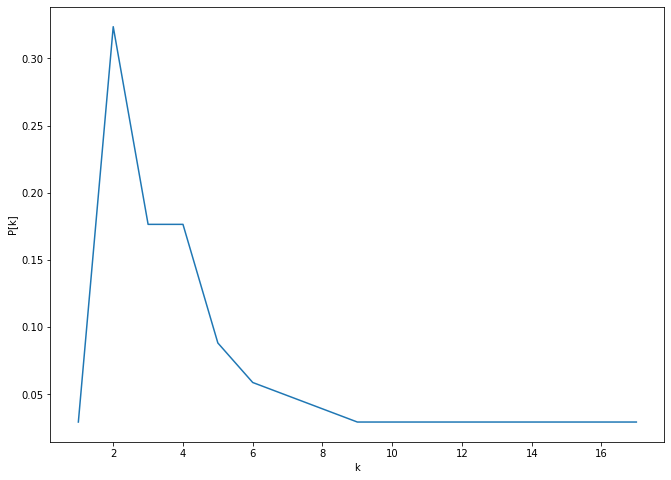

In [47]:
plt.plot(Pk.T[0], Pk.T[1])
plt.xlabel('k')
plt.ylabel('P[k]')
plt.gcf().set_size_inches(11, 8)

The average degree of the nearest neighbours as a function of the degree is:

In [48]:
knn = Karate.neighbour_degree_function()

Which we plot as well

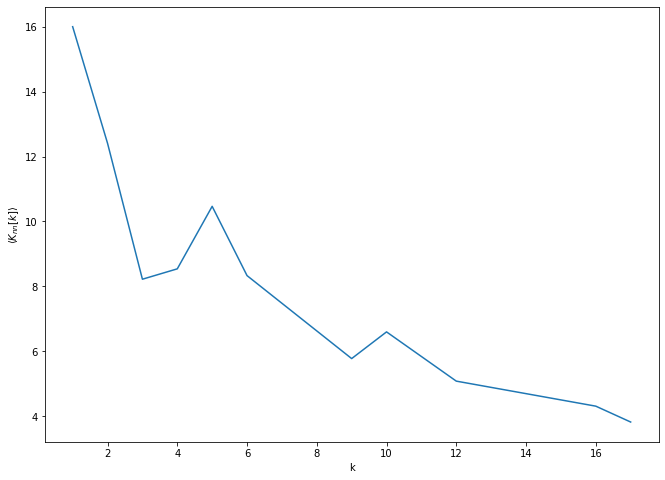

In [49]:
plt.plot(knn.T[0], knn.T[1])
plt.xlabel('k')
plt.ylabel(r'$\langle K_{nn}[k] \rangle$')
plt.gcf().set_size_inches(11, 8)

Finally, before we proceed to the next nodebook, we save the current state of our Graph class. For this we use some Jupyter Notebook magic. It's not important to understand this, but you can read about it in the [Jupyter notebook](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html) documentation.

In [50]:
def export_class(path, filename):
    import io
    from nbformat import read

    with io.open(path, 'r', encoding='utf-8') as f:
        nb = read(f, 4)

    fp = open(filename, "wt")

    for cell in nb.cells:
        if cell.cell_type == 'code':
            first_line = cell.source.split('\n')[0]
            
            if "class " in first_line or "add_method" in first_line in first_line:
                print(cell.source, file=fp)

                print("\n", file=fp)

    fp.close()

Suffice it to say, that after this line, we'll have a Python module called "Graph.py" containing all the methors in our Graph class

In [51]:
export_class('2 - Graph Properties.ipynb', 'Graph.py')